In [567]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats 

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset

# imports from captum library
from captum.attr import GradientShap,FeatureAblation

from grid_search import grid_search

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [568]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,scipy,torch,captum,scikit-learn -g


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.1
IPython version      : 8.24.0

numpy       : 1.26.4
pandas      : 2.2.2
matplotlib  : 3.8.4
scipy       : 1.13.0
torch       : 2.3.0
captum      : 0.7.0
scikit-learn: 1.4.2

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: bc66727f831e9b15d2a5dbb21d1ee4799307c18e



In [569]:
BD_synthetic = pd.read_csv('../data/BD_synthetic.csv', index_col=False)
HC_synthetic = pd.read_csv('../data/HC_synthetic.csv', index_col=False)

In [570]:
# helper functions
def selectFeatures(df, feature_names):
    contains_columns = df.columns.str.contains(feature_names)
    subset_df = df.iloc[:, contains_columns]
    return subset_df

In [571]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal|Age' # select features that are correlated with BD vs. HC differences found in previous studies
HC_synthetic = selectFeatures(HC_synthetic, pattern) 

In [572]:
X = HC_synthetic.drop(columns=['Age at Visit']).values  
y = HC_synthetic['Age at Visit'].values 

In [573]:
normalized_X = X- np.min(X)/np.max(X) - np.min(X) # MinMax normalization

In [574]:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.3, random_state=0) # create test and train sets

In [575]:
tstat, p_val = stats.ttest_ind(y_train, y_test) # ensure that the distribution of ages between the train and test sets are similar by doing a t-test
print(tstat, p_val)

-0.4432134092121586 0.6584228995793475


### Tensorize the datasets

In [576]:
X_train = torch.tensor(X_train).float() # convert arrays to tensors
y_train = torch.tensor(y_train).view(-1, 1).float() 

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

In [577]:
param_grid = {
    'batch_size': [32, 50, 64, 128],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'size_hidden1': [50, 100, 150],
    'size_hidden2': [25, 50, 75],
    'size_hidden3': [5, 10, 20],
    'num_epochs': [50, 100, 150]  # This is typically fixed during a single round of experiments
}

val_data = TensorDataset(X_train[60:], y_train[60:])
train_data =  TensorDataset(X_train[:60], y_train[:60])
model = BrainAgeModel(9)
best_params, best_score = grid_search(model, param_grid,train_data, val_data)

stats.ttest_ind(y_train[60:], y_test[:60])

Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 5, 'num_epochs': 50} Score: 123.31897735595703
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 5, 'num_epochs': 100} Score: 111.51578521728516
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 5, 'num_epochs': 150} Score: 115.70831298828125
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 50} Score: 111.23360443115234
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 100} Score: 108.02224731445312
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 150} Score: 118.59220123291016
Tested Params: {'batch_size

TtestResult(statistic=array([-1.0635605], dtype=float32), pvalue=array([0.29193594]), df=array([58.]))

In [578]:
print(best_params, best_score)

{'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 100} 108.02224731445312


### Create a Python class to represent the Brain Age Model

In [579]:
# Define hyperparameters for the model based on what we found above in grid search
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']
learning_rate = best_params['learning_rate']
size_hidden1 = best_params['size_hidden1'] # certain params are hard coded into the function below
size_hidden2 = best_params['size_hidden2']
size_hidden3 = best_params['size_hidden3']
size_hidden4 = 1

datasets = TensorDataset(X_train, y_train)
train_iter = DataLoader(datasets, batch_size, shuffle=True)

# Create a class representing a brain age prediction model based on 4 layers of NNs
class BrainAgeModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # First layer: linear transformation from input size to first hidden layer size
        self.lin1 = nn.Linear(input_size, size_hidden1)
        # Activation function for the first hidden layer
        self.relu1 = nn.ReLU()
        # Second layer: linear transformation from first to second hidden layer size
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        # Activation function for the second hidden layer
        self.relu2 = nn.ReLU()
        # Third layer: linear transformation from second to third hidden layer size
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        # Activation function for the third hidden layer
        self.relu3 = nn.ReLU()
        # Output layer: linear transformation from third hidden layer size to output size
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        # Define the forward pass through the network
        x = self.lin1(input)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin4(x)
        return x

In [580]:

model.train()

BrainAgeModel(
  (lin1): Linear(in_features=9, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=25, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=25, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [581]:
criterion = nn.MSELoss(reduction='sum')

In [582]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

### Test model on data from healthy individuals 

In [583]:
model.eval()
y_pred = model(X_test)
err = (mean_squared_error(y_pred.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  299.39758


In [584]:
mean_absolute_error(y_pred.detach().numpy(), y_test.detach().numpy())

13.835461

In [585]:
gs = GradientShap(model)
fa = FeatureAblation(model)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

In [586]:
features = HC_synthetic.iloc[:, 1:].columns

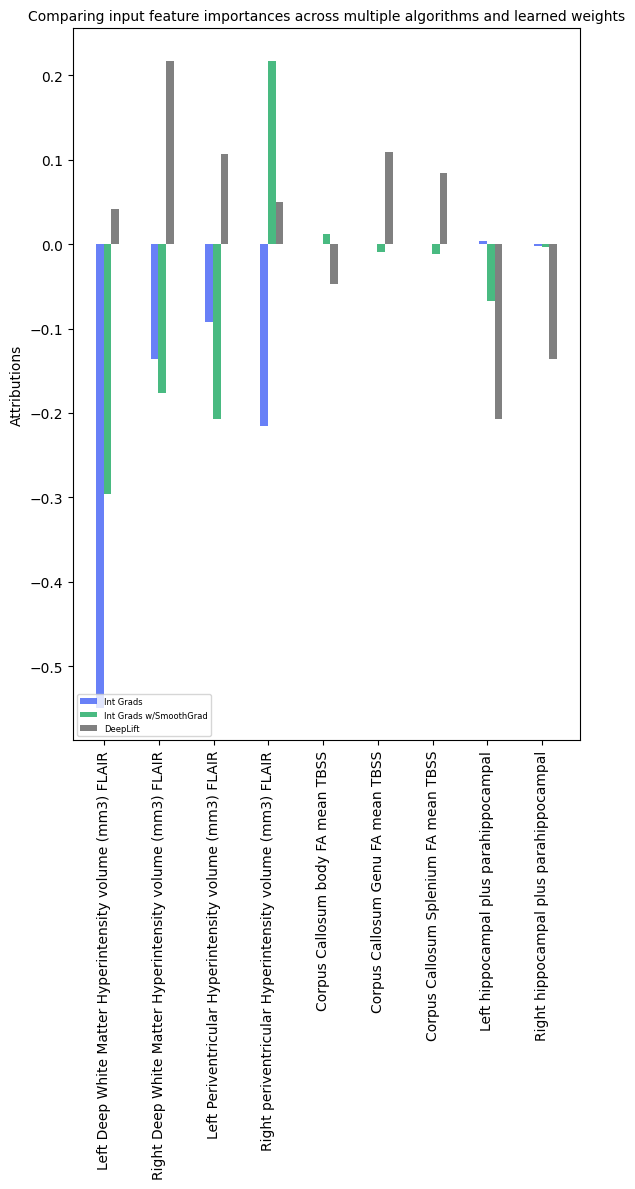

In [587]:
# Sample data preparation and other variables might be defined here
# Since I don't have access to your specific data or full code, this is an example modification

plt.figure(figsize=(6, 12))
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 10
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

width = 0.14  # Assuming this variable setup exists

# Assuming that x_axis_data and plotting data are set up correctly
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')

ax.set_xticks(x_axis_data + 0.5)  # Adjust as per your code structure
ax.set_xticklabels(x_axis_data_labels, rotation=90)  # Rotation added here

plt.legend(legends, loc=3)
plt.tight_layout()  # Ensures everything fits without overlap
plt.show()


### Test model on data from individuals with BD

In [588]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal|Age'
BD_X = selectFeatures(BD_synthetic, pattern)
BD_X = BD_X.drop(columns= ['Age at Visit']).values
BD_y = BD_synthetic['Age at Visit'].values

In [589]:
normalized_BD_X = BD_X - np.min(BD_X)/(np.max(BD_X)- np.min(BD_X))

In [590]:
normalized_BD_X = torch.tensor(normalized_BD_X).float()
BD_y = torch.tensor(BD_y).view(-1, 1).float()

In [591]:
model.eval()
BD_y_pred = model(normalized_BD_X)


In [592]:
err = (mean_squared_error(BD_y_pred.detach().numpy(), BD_y.detach().numpy()))
print(err)
err = (mean_absolute_error(BD_y_pred.detach().numpy(), BD_y.detach().numpy()))
print(err)

1746.4109
39.768204
